In [2]:
# common imports
import numpy as np
import pandas as pd

Data Sourced from: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

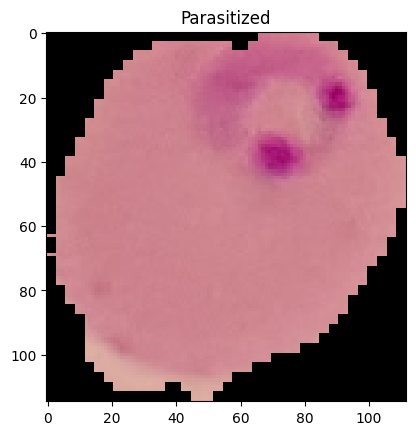

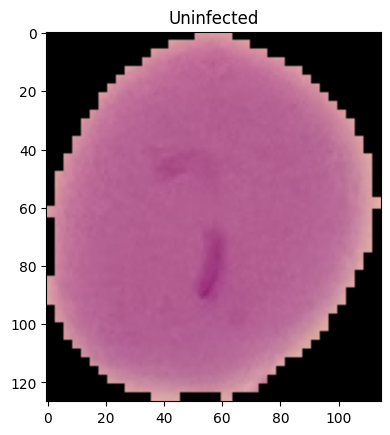

In [8]:
import matplotlib.pyplot as plt
import os
import cv2

# import the data 
data_dir = "Malaria_CNN/cell_images" # load in the images 

# remove any .DS_Store files 
for root, dirs, files in os.walk(data_dir):
    for f in files:
        if f == ".DS_Store":
            os.remove(os.path.join(root, f))

#specify categories
for category in ["Parasitized", "Uninfected"]:
    path = os.path.join(data_dir, category)
    img = cv2.imread(os.path.join(path, os.listdir(path)[0]))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(category)
    plt.show()


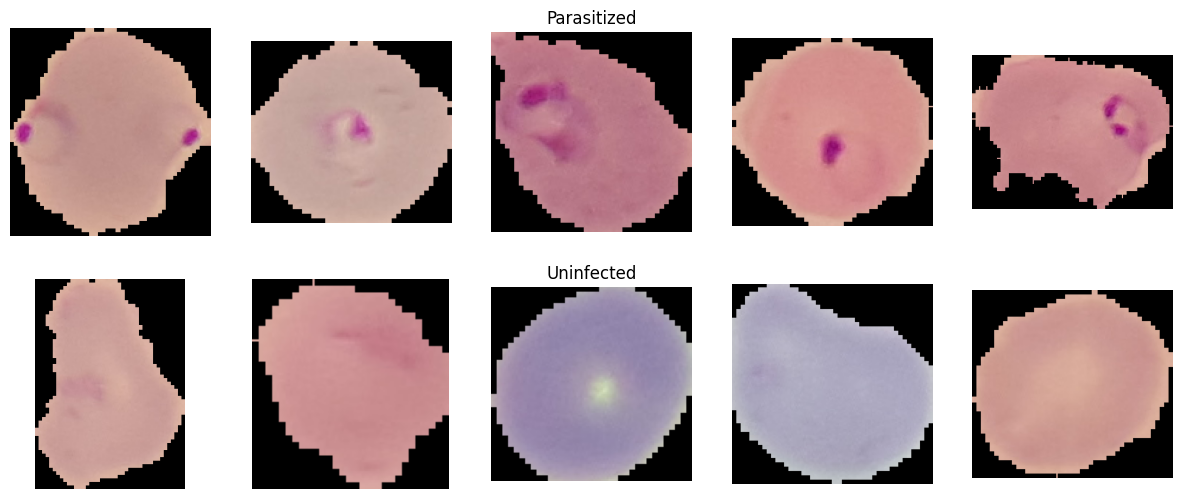

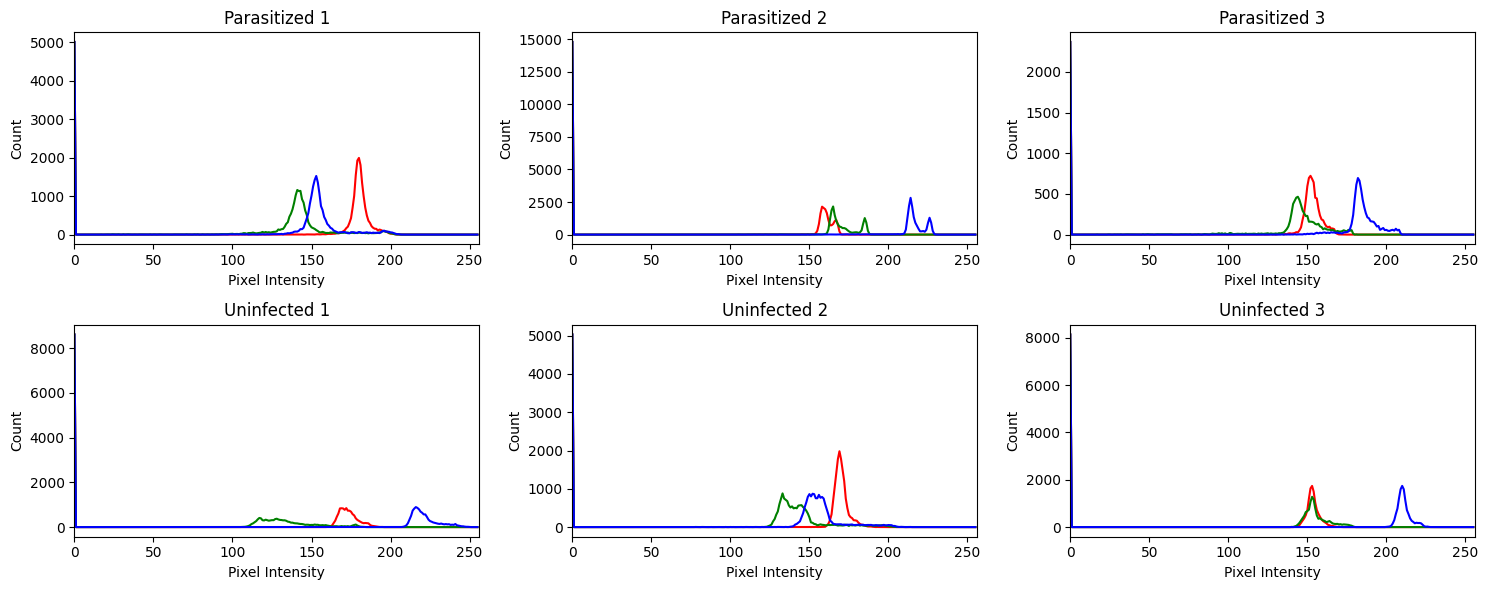

In [4]:
#visualize variation in cell staining, look at random samples side by side and compare histograms of pixel intensity
import matplotlib.pyplot as plt
import os
import random
import cv2 

data_dir = "Malaria_CNN/cell_images" #import the images 

categories = ["Parasitized", "Uninfected"] #categorize the images 

fig, axes = plt.subplots(2, 5, figsize=(15,6)) #create grid of subplots
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    files = random.sample(os.listdir(path), 5)  # pick 5 random images
    for j, file in enumerate(files):
        img = cv2.imread(os.path.join(path, file)) # load in image 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 2:  # label the middle image
            axes[i, j].set_title(category)
plt.show()


#color histogram analysis for single sample
num_images = 3
fig, axes = plt.subplots(len(categories), num_images, figsize=(15,6)) #plot several histograms 

for i, category in enumerate(categories):
    path = os.path.join(data_dir, category) # loop over the folder 
    files = random.sample(os.listdir(path), num_images)  # pick random images
    
    for j, file in enumerate(files):
        img = cv2.imread(os.path.join(path, file))
        
        # Plot histograms
        colors = ('r','g','b')
        for k, col in enumerate(colors):
            hist = cv2.calcHist([img],[k],None,[256],[0,256])
            axes[i, j].plot(hist, color=col)
        
        axes[i, j].set_xlim([0,256])
        axes[i, j].set_title(f"{category} {j+1}")
        axes[i, j].set_xlabel("Pixel Intensity")
        axes[i, j].set_ylabel("Count")

plt.tight_layout()
plt.show()

Sample notes:
- Schuffner's dots in malaria+ RBC (P.ovale subspecies)
- RBC Stained with Giemsa 
- Variability in cell staining is significant

In [5]:
#check class balance
counts = {}
for cat in categories:
    path = os.path.join(data_dir, cat)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    counts[cat] = len(files)

print(counts) 

{'Parasitized': 13779, 'Uninfected': 13779}


In [9]:
#image preprocessing
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#parameters 
img_size = (128, 128)
batch_size = 32

#data generators for training and validation 
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalize to [0,1]
    validation_split=0.2, #80 / 20 train/ val split 
    rotation_range=15, # small rotation  
    width_shift_range=0.1, #horizontal shifts 
    height_shift_range=0.1, #vertical shifts 
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2] #simulate straining variation
)

#training set 
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

#validation set
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

#check for correct subfolders in directory 
print("Subfolders in data_dir:", os.listdir(data_dir))

for category in os.listdir(data_dir):
    path = os.path.join(data_dir, category)
    if os.path.isdir(path):
        print(category, "->", len(os.listdir(path)), "files")


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Subfolders in data_dir: ['Parasitized', 'Uninfected']
Parasitized -> 13780 files
Uninfected -> 13780 files


Epoch 1/5
689/689 [==============================] - 79s 112ms/step - loss: 0.3016 - accuracy: 0.8766 - val_loss: 0.2319 - val_accuracy: 0.9122
Epoch 2/5
689/689 [==============================] - 78s 113ms/step - loss: 0.2429 - accuracy: 0.9051 - val_loss: 0.2290 - val_accuracy: 0.9078
Epoch 3/5
689/689 [==============================] - 73s 106ms/step - loss: 0.2301 - accuracy: 0.9136 - val_loss: 0.2159 - val_accuracy: 0.9151
Epoch 4/5
689/689 [==============================] - 73s 106ms/step - loss: 0.2242 - accuracy: 0.9168 - val_loss: 0.2067 - val_accuracy: 0.9187
Epoch 5/5
689/689 [==============================] - 73s 106ms/step - loss: 0.2200 - accuracy: 0.9167 - val_loss: 0.2349 - val_accuracy: 0.9103


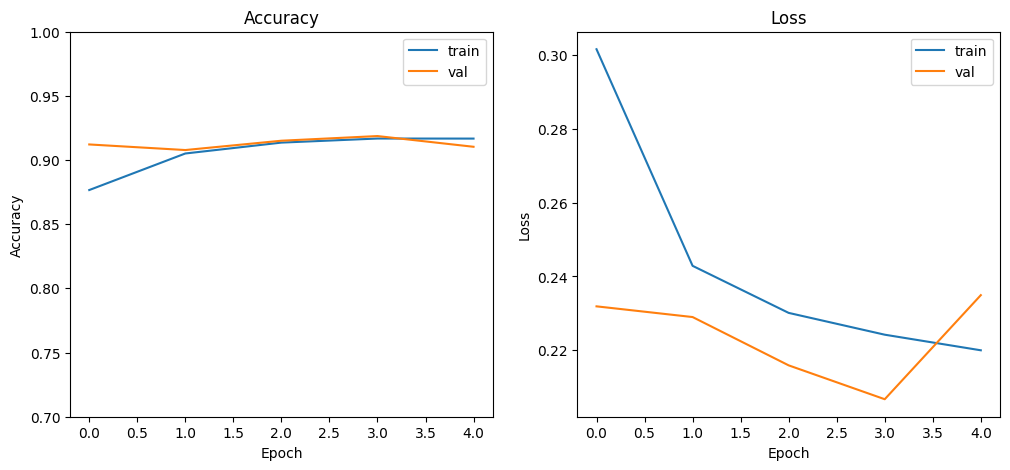

In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# load pretrained MobileNetV2 (without the top FC layers)
base_model = MobileNetV2(
    weights="imagenet",      # start with ImageNet weights
    include_top=False,       # remove the classifier head
    input_shape=(128,128,3)  # match our data size
)
base_model.trainable = False   # freeze the backbone initially

# new classification model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),   # flatten feature maps
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# training
hist = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


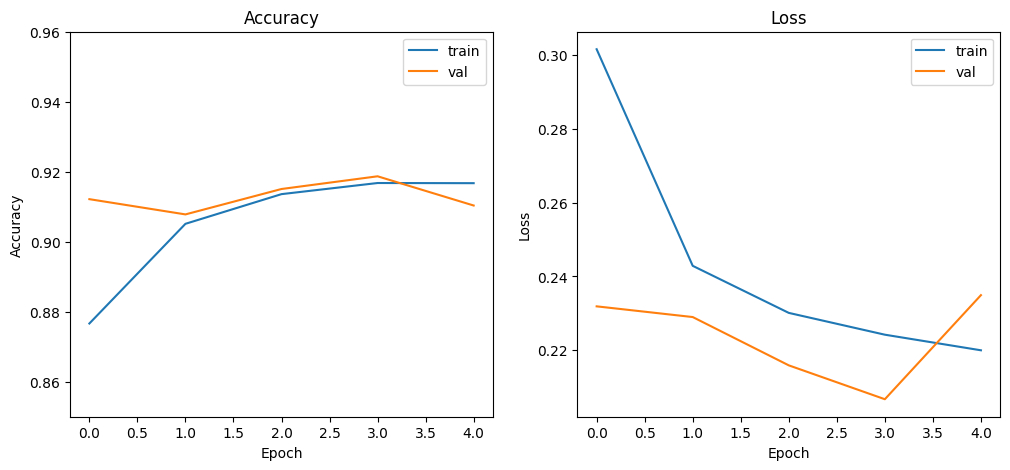

In [15]:
#plot accuracy and loss 

plt.figure(figsize=(12,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.85, 0.96)
plt.legend()

# loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.xticks()
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
#fine-tune the model to improve the accuracy, recall, F1 score 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# load pretrained MobileNetV2 without the top layers
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

# unfreeze last 20 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# build model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# compile with a low learning rate for fine-tuning
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# fine-tune
hist_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5  
)


Epoch 1/5
689/689 [==============================] - 85s 122ms/step - loss: 0.3816 - accuracy: 0.8245 - val_loss: 0.4715 - val_accuracy: 0.8105
Epoch 2/5
689/689 [==============================] - 81s 118ms/step - loss: 0.2486 - accuracy: 0.9013 - val_loss: 0.2678 - val_accuracy: 0.8976
Epoch 3/5
689/689 [==============================] - 80s 116ms/step - loss: 0.2141 - accuracy: 0.9199 - val_loss: 0.1950 - val_accuracy: 0.9290
Epoch 4/5
689/689 [==============================] - 77s 112ms/step - loss: 0.1957 - accuracy: 0.9287 - val_loss: 0.1858 - val_accuracy: 0.9327
Epoch 5/5
689/689 [==============================] - 76s 110ms/step - loss: 0.1749 - accuracy: 0.9356 - val_loss: 0.1843 - val_accuracy: 0.9358


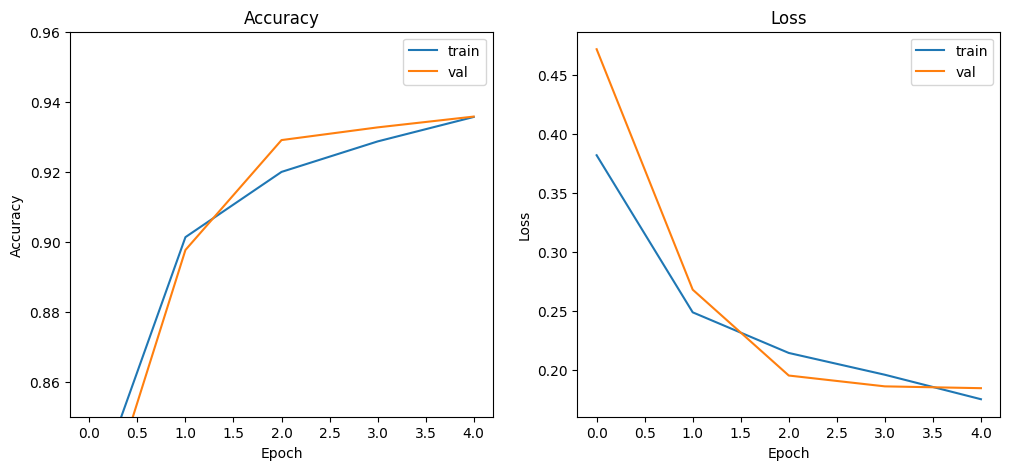

In [18]:
#plot accuracy and loss 

plt.figure(figsize=(12,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(hist_finetune.history['accuracy'], label='train')
plt.plot(hist_finetune.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.85, 0.96)
plt.legend()

# loss
plt.subplot(1,2,2)
plt.plot(hist_finetune.history['loss'], label='train')
plt.plot(hist_finetune.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.xticks()
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
#precision, recall, F1 score 

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_images, test_labels = next(val_generator)  # or use a proper test generator
preds = model.predict(test_images)
preds_class = (preds > 0.5).astype(int)

print(classification_report(test_labels, preds_class))
print(confusion_matrix(test_labels, preds_class))


1/1 [==============================] - 0s 379ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        15
         1.0       0.94      1.00      0.97        17

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32

[[14  1]
 [ 0 17]]


In [ ]:
model.save('malaria_mobilenet2_finetuned.h5')